# 1.1) Source Code

In [81]:
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 데이터 준비

In [16]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [17]:
data.sample(10)

,headlines,text
53836,Apple battery replacement may cut iPhone sales...,Apple's offer to replace batteries at $29 may ...
10786,"2,000-year-old wine discovered from ancient to...","Archaeologists have discovered a nearly 2,000-..."
60411,Get well soon: Taapsee to troll who slammed he...,"Taapsee Pannu, while responding to a troll on ..."
19688,Volkswagen backed Tesla's bid to go private: R...,Volkswagen was reportedly one of the companies...
30557,Bobby Darling's husband jailed for domestic ab...,"Pakhi Sharma, formerly known as Bobby Darling,..."
7358,"Woman sues Hilton for $100mn, says hotel worke...",A Chicago woman has sued Hilton Worldwide for ...
45381,Raina batted vs SA like he was never out of te...,"Talking about Suresh Raina, who recently made ..."
92071,White House sidewalk to be closed to public pe...,The sidewalk along the south fence of the Whit...
6243,Former AMMK leader Senthil Balaji joins DMK,Amma Makkal Munnettra Kazagam (AMMK) chief TTV...
16345,Pablo Escobar museum shut down in Colombia,A museum dedicated to drug lord Pablo Escobar ...


- News 데이터와 헤드라인을 불러와 sample 을 확인합니다.

In [18]:
print('전체 샘플수 :', len(data))

전체 샘플수 : 98401


### 데이터 전처리

In [19]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


- Text 에서 중복을 제외한다면, 98360 개
- Headlines 에서 중복을 제외한다면, 98280 개

In [20]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', len(data))

전체 샘플수 : 98360


- text 열에서 중복을 제거합니다.
- headlines 는 해당 기사에 대한 요약이므로 중복될 수 있습니다.

In [21]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 데이터에 null 값이 존재하는지 확인합니다.

In [22]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- 텍스트 정규화를 위한 사전을 구성하였습니다.
- 같은 의미를 가진 다른 표현들을 하나의 단어로 간주할 수 있도록 하기 위함입니다.

In [23]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- 불용어 처리를 위해 NLTK 에서 제공하는 불용어 리스트를 참조합니다.

In [24]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)

    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- 데이터 전처리를 자동화하는 함수를 정의하였습니다.
- 문장을 영문 소문자로 변환 뒤, lxml parser 로 파싱(parsing) 해줍니다.
- 괄호로 닫힌 내용들을 삭제합니다.
- 큰 따옴표를 제거합니다.
- 앞서 정의한 사전을 활용하여 텍스트를 정규화합니다.
- 소유격을 제거합니다.
- 알파벳 이외의 문자를 공백으로 변환합니다.

- 불용어 처리의 경우에는 text 열에만 적용해주도록 하겠습니다.
- headlines 는 이미 문장의 길이가 짧으며,
- 추상적 요약 시, 자연스러운 문장을 반환하기 위해서는 불용어들이 필요하다고 판단하였습니다.

In [25]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_headlines, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


- 함수가 정상적으로 작동하는지 확인해주었습니다.

In [26]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [27]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


-  text 와 headlines 에 대한 문장 전처리 작업을 수행하였습니다.
- headlines 에서는 불용어 제거를 수행하지 않았습니다.

In [28]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

- 전처리가 끝난 문장들을 다시 데이터프레임에 저장해주었습니다.
- 전처리 과정에서 빈 값을 가진 데이터가 생겼을 가능성이 있습니다.
- 따라서, 빈 값을 NaN 으로 대체하여주었습니다.

In [30]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

- null 값의 개수를 조회합니다.

text의 최소 길이 : 1
text의 최대 길이 : 60
text의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


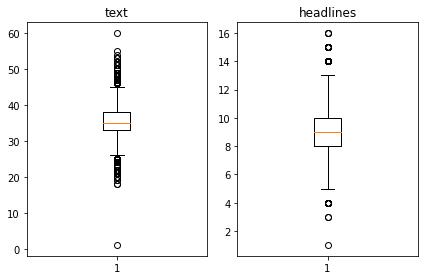

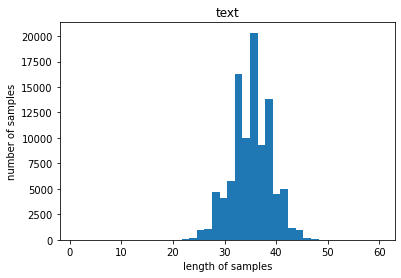

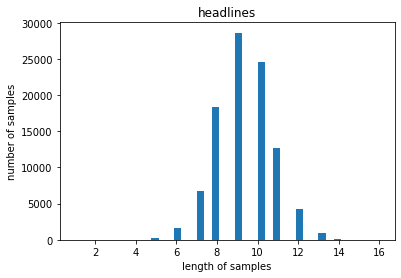

In [33]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text의 최소 길이 : {}'.format(np.min(text_len)))
print('text의 최대 길이 : {}'.format(np.max(text_len)))
print('text의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- text 와 headlines 의 최대 길이를 설정하기 위해 각 컬럼의 문장 길이 분포를 시각화하였습니다.
- text 와 headlines 의 평균 길이는 각각 35, 9 인 것을 알 수 있습니다.
- 아래 그래프에서 text 는 대체적으로 44 이하, headlines 는 12 이하의 문장 길이를 가지고 있음을 확인할 수 있습니다.

In [37]:
text_max_len = 40
headlines_max_len = 10

- 따라서, text 는 40, headlines 는 10 로 최대 길이를 설정하였습니다.
- 밑에서는 위에서 설정한 최대 길이가 적절한지 통계로 확인해보겠습니다.

In [38]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 {} 이하인 샘플의 비율: {}'.format(max_len, (cnt / len(nested_list))))

- 최대 길이 내 데이터의 비율을 출력하는 함수를 정의하였습니다.

In [39]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


- 각각 40, 10 으로 최대 길이를 설정하였을 경우, 92%, 81% 의 데이터들을 온전히 사용할 수 있습니다.

In [40]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', len(data))

전체 샘플수 : 74102


- text 열에서 길이가 40 이하인 데이터를 제외하고 삭제해주었습니다.
- headlines 열에서는 길이가 10 이하인 데이터를 제외하고 삭제해주었습니다.
- 전체 데이터 수는 74102 개가 되었습니다.

- seq2seq 의 training 시에는 decoder의 input과 target 을 모두 지정해주어야합니다.
- 따라서, decoder 의 input 앞에는 'sostoken',
- decoder 의 target 뒤에는 'eostoken' 을 추가해주도록 하겠습니다.
- headlines 열을 사용하여야합니다.

In [41]:
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [46]:
data.loc[2, 'decoder_target']

'new zealand end rohit sharma led india match winning streak eostoken'

- data 의 앞뒤로 sostoken 과 eostoken 이 잘 붙어있습니다.

In [47]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

- encoder 의 입력값, decoder 의 입력값, decoder 의 target 을 ndarray type 으로 변환하여 주었습니다.

- 이제 준비된 dataset 을 train data 와 test data 로 분리하여 주겠습니다.

In [48]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

print(indices)

[66870  5641 62812 ... 42863 73116 24701]


- 데이터를 shuffling 하기 위해 random 한 정수 시퀀스를 생성해주었습니다.

In [49]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- 정수 시퀀스를 활용하여 데이터를 shuffling 해주었습니다.

In [50]:
n_of_val = int(len(encoder_input) * 0.2)
print("test data 개수: ", n_of_val)

test data 개수:  14820


- 8:2 의 비율로 dataset 을 분리하도록 하겠습니다.
- 따라서, test data 의 수는 14820 개입니다.

In [51]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


- train data 의 개수는 59282,
- test data 의 개수는 14820 으로 분리되었습니다.

In [52]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

- encoder_input data 를 정수 인코딩한 후, model 에 입력해주어야 합니다.
- keras 의 tokenizer 를 활용하여 encoder_input_train data 를 토큰화하고,
- 단어집합(vocabulary) 를 생성합니다.

In [53]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기: {}'.format(total_cnt))
print('등장 빈도가 {}번 이하인 희귀 단어의 수: {}'.format(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: {}'.format(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율: {}".format((rare_cnt / total_cnt) * 100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {}".format((rare_freq / total_freq) * 100))

단어 집합(vocabulary)의 크기: 61526
등장 빈도가 6번 이하인 희귀 단어의 수: 42220
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 19306
단어 집합에서 희귀 단어의 비율: 68.62139583265612
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.186763669011215


- 생성된 vocabulary 에서 빈도수가 낮은 단어는 제외하고 사용하도록 하겠습니다.
- total_cnt 는 단어의 총 개수입니다.
- rare_cnt 는 threshold 보다 낮은 등장 빈도수를 가지는 단어의 총 개수입니다.
- total_freq 는 단어의 빈도수 총합입니다.
- rare_freq 는 threshold 보다 낮은 등장 빈도수를 가지는 단어의 빈도수 총합입니다.
- tokenizer 의 word_counts 에는 각 단어와 단어의 빈도수가 저장되어 있습니다.

- encoder_input_train 에는 61526 개의 단어가 있습니다.
- 그 중, 6번 이하의 등장 빈도를 가지는 단어는 42220 개로 단어집합에서 68%의 비율을 차지하고 있습니다.
- 그러나, 실제로 6번 이하의 등장 빈도를 가지는 희귀 단어가 등장한 실제 빈도는 4.19% 밖에 되지 않습니다.
- 따라서, 등장 빈도가 6번 이하인 단어들은 정수 인코딩에서 제외하여 training 시 사용하지 않도록 하겠습니다.

In [54]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

- 희귀 단어를 제외한 단어 집합의 크기를 약 19000으로 잡았습니다.
- 단어장의 크기를 19000으로 설정하고 다시 단어집합을 생성해줍니다.

In [55]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[647, 380, 4873, 6987, 373, 57, 6075, 5148, 222, 16, 12, 5076, 90, 2005, 6075, 5076, 1107, 2411, 203, 8806, 4046, 295, 40, 15896, 804, 66, 6, 90, 369, 1950, 6075, 13175, 122, 3647, 13, 12, 245], [607, 2547, 8807, 52, 1, 5732, 7765, 1198, 29, 338, 133, 530, 870, 686, 3222, 445, 3247, 7624, 3160, 86, 687, 5204, 3087, 394, 29, 329, 5465, 2981, 133, 20, 1725, 607, 8, 2944, 677, 8807], [62, 237, 107, 1665, 630, 48, 719, 429, 2522, 1087, 86, 571, 148, 405, 1413, 2248, 258, 215, 2982, 4086, 62, 534, 1186, 2087]]


- 앞서 생성한 단어장을 활용하여 encoder_input data 를 정수인코딩해주었습니다.
- 각 문장의 token 들이 단어장의 index 를 기반으로 int type 으로 변환되었습니다.

In [56]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

- encoder_input data 는 단어장이 생성되었고, 정수 인코딩도 완료되었습니다.
- decoder_input data 도 마찬가지로 단어장 생성 및 정수 인코딩을 수행하겠습니다.

In [57]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기: {}'.format(total_cnt))
print('등장 빈도가 {}번 이하인 희귀 단어의 수: {}'.format(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: {}'.format(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율: {}".format((rare_cnt / total_cnt) * 100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {}".format((rare_freq / total_freq) * 100))

단어 집합(vocabulary)의 크기: 27325
등장 빈도가 5번 이하인 희귀 단어의 수: 18240
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 9085
단어 집합에서 희귀 단어의 비율: 66.75205855443733
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.964105856141929


- decoder_input_train 은 총 27325 개의 단어로 구성되어 있습니다.
- 이 중 등장 빈도가 5번 이하인 희귀 단어는 18240 개로 전체 단어 중 66% 의 비율을 차지하고 있습니다.
- 그러나, 실제로 희귀 단어가 등장하는 빈도는 전체 빈도 중 약 6% 에 불과합니다.
- 따라서, 등장 빈도 5번 이하인 단어들에 대해서만 단어장을 생성하여 training 시 반영하도록 하겠습니다.

In [58]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

- decoder_input_train 과 decoder_target_train을 토큰화하고 9000 개 크기의 단어장을 생성해주었습니다.

In [59]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

- decoder_input_train, test 와 decoder_target_train, test 를 앞서 생성한 단어장을 활용하여 정수 인코딩 해주었습니다.

In [61]:
print('input')
print('decoder ', decoder_input_train[:5])
print('target')
print('decoder ', decoder_target_train[:5])

input
decoder  [[1, 4327, 19, 1127, 5677, 3, 333, 4328, 6, 262, 3454], [1, 6934, 6463, 3, 1408, 6464, 67, 541, 484, 4, 350], [1, 3838, 3238, 2414, 753, 4683, 277, 12, 2615], [1, 839, 371, 96, 15, 7555, 6935, 4, 3698], [1, 113, 2616, 1054, 1175, 12, 511, 7, 1878]]
target
decoder  [[4327, 19, 1127, 5677, 3, 333, 4328, 6, 262, 3454, 2], [6934, 6463, 3, 1408, 6464, 67, 541, 484, 4, 350, 2], [3838, 3238, 2414, 753, 4683, 277, 12, 2615, 2], [839, 371, 96, 15, 7555, 6935, 4, 3698, 2], [113, 2616, 1054, 1175, 12, 511, 7, 1878, 2]]


- decoder 의 input 과 target 이 정상적으로 정수 인코딩되었습니다.

- 단어장을 생성하고 정수 인코딩을 수행하는 과정에서 빈도수가 낮은 단어들로만 이루어진 문장의 경우에는 삭제되었을 확률이 높습니다.
- 특히나, text 열로 이루어진 encoder_input data 의 경우에는 확률이 낮지만,
- headlines 열로 이루어진 decoder_input, decoder_target data 의 경우에는 모든 토큰이 삭제되었을 확률이 높습니다.
- 따라서, 모든 문장이 삭제된 data 를 찾아보겠습니다.

In [62]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


- 모든 decoder_input 에는 앞서 sostoken 을 추가해주었고,
- 모든 decoder_target 에는 eostoken 을 추가해주었으므로,
- 빈도수가 낮아 모든 토큰이 삭제되었다고 하더라도 sostoken 과 eostoken 은 남아있을 것입니다.
- 따라서, 문장의 길이가 1 인 데이터를 찾아보았습니다.
- 다행히, 모든 토큰이 제거된 문장은 없습니다.

In [63]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding = 'post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding = 'post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding = 'post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding = 'post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding = 'post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding = 'post')

- 이제 모든 data 가 정수 인코딩 되었으므로, 패딩을 추가해주었습니다.
- pad_sequences() 를 이용하면 손쉽게 원하는 위치에 패딩을 추가해줄 수 있습니다.
- 앞서 설정한 max_len 을 기준으로 문장의 뒤에 숫자 0 을 추가하였습니다.

### 모델링

In [92]:
# Encoder
embedding_dim = 256
hidden_size = 384

# Encoder Input
encoder_inputs = Input(shape=(text_max_len,))

# Encoder Embedding Layer
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# Encoder LSTM Layer_1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM Layer_2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM Layer_3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

- Encoder 를 모델링해주었습니다.
- 임베딩 차원 수는 256 으로 설정해주었고, hidden state 의 크기는 512 로 설정하였습니다.
- hidden state 는 LSTM Layer 에서 뉴런의 개수를 의미합니다.
- 또한, Encoder 는 총 3 개의 LSTM Layer 로 구성해주었습니다.
- 모델의 과적합을 최대한 줄여주기 위해 dropout 과 recurrent dropout 을 사용하였습니다.
- 일반적인 dropout 은 Layer 의 weight 을 랜덤으로 생략해주지만, recurrent dropout 을 함께 사용하면, time step 마다 입력을 랜덤으로 생략할 수 있습니다.
- 이제 Encoder 에서 3 개의 층을 통과한 출력 벡터를 Decoder 로 전달해주어야 합니다.

In [93]:
# Decoder Input
decoder_inputs = Input(shape=(None,))

# Decoder Embedding Layer
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM Layer_1
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True,
                    dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- Decoder 를 모델링해주었습니다.
- Decoder 에서는 LSTM Layer 1 개를 사용하였습니다.
- Encoder 의 hidden_state 와 cell_state 를 Decoder 의 LSTM Layer 생성 시, 파라미터로 넣어주어야 합니다.
- 이제 Attention Layer 를 결합한 Decoder 의 출력층을 설계해보겠습니다.

In [94]:
# Attention Layer
attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# Concatenate attn_out and decoder_outputs
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

- Attention Layer 를 설계하였습니다.
- tensorflow 에서는 Attention Function 을 API 로 제공하고 있습니다.
- Encoder output 과 Decoder output 을 Attention Layer 로 전달하여 출력을 반환합니다.
- 이후, Concat Layer 에서 Attention Layer 의 출력값과 Decoder 의 hidden_state 들을 연결합니다.

In [95]:
# Decoder Output Layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

- Decoder 의 Output Layer 에서는 tar_vocab 내의 단어들 중 다음에 나올 단어들의 각 확률을 반환하는 Softmax 활성화함수를 사용하고 있습니다.

In [96]:
# Define Model
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 40, 256)      4864000     input_12[0][0]                   
__________________________________________________________________________________________________
lstm_19 (LSTM)                  [(None, 40, 384), (N 984576      embedding_9[0][0]                
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

- 즉, Encoder 의 hidden_state 와 Decoder 의 hidden_state 들을 Attention Layer 의 Input 으로하여 리턴한 값을 예측 시에 Decoder 의 hidden_state 와 결합하여 활용하는 형태입니다. 

### 훈련

In [97]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 140s 571ms/step - loss: 6.2271 - val_loss: 5.8140
Epoch 2/50
232/232 [==============================] - 132s 568ms/step - loss: 5.6264 - val_loss: 5.3702
Epoch 3/50
232/232 [==============================] - 131s 566ms/step - loss: 5.1799 - val_loss: 4.9996
Epoch 4/50
232/232 [==============================] - 131s 563ms/step - loss: 4.8380 - val_loss: 4.7850
Epoch 5/50
232/232 [==============================] - 132s 568ms/step - loss: 4.5659 - val_loss: 4.6278
Epoch 6/50
232/232 [==============================] - 131s 563ms/step - loss: 4.3354 - val_loss: 4.4910
Epoch 7/50
232/232 [==============================] - 132s 567ms/step - loss: 4.1348 - val_loss: 4.4123
Epoch 8/50
232/232 [==============================] - 131s 563ms/step - loss: 3.9535 - val_loss: 4.3272
Epoch 9/50
232/232 [==============================] - 131s 564ms/step - loss: 3.7906 - val_loss: 4.2692
Epoch 10/50
232/232 [==============================] - 131s 564m

- early stopping 은 검증 데이터의 loss 가 증가하는 현상이 2회 관측될 경우, 학습을 중단하도록 설정되어 있습니다.
- 훈련 데이터의 loss 와 검증 데이터의 loss 를 시각화하겠습니다.

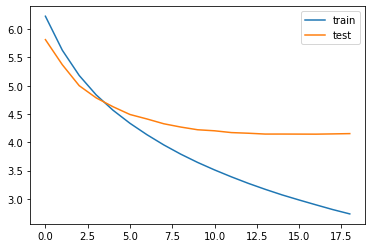

In [98]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 테스트

- 학습이 종료되었으므로, 훈련된 모델을 테스트해보도록 하겠습니다.

In [103]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

- 테스트 시에는 정수 인코딩된 데이터들을 실제 문장 데이터로 복원해주어야 합니다.
- 따라서, 3 개의 사전을 준비해두겠습니다.

- 테스트 시 사용할 모델은 훈련 시 설계했던 모델과 달라 별도로 구현해주어야 합니다.
- 훈련 시 설계했던 모델은 decoder 의 Input 에 정답이 되는 target data 를 같이 넣어주어 출력과 한 번에 비교할 수 있었지만,
- 실제 테스트 시에는 정답이 되는 문장이 없으므로, 생성해내야할 문장의 길이만큼 Decoder 가 반복적으로 동작하여야 하기 때문입니다.

In [104]:
# Encoder
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# state Tensor
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

- decoder_state_input_h 와 decoder_state_input_c 는 이전 시점의 hidden_state 와 cell_state 를 저장하는 텐서입니다.
- 문장의 다음 단어를 예측하기 위해서 initial_state 를 이전 시점의 hidden_state 와 cell_state 로 설정합니다.
- 훈련 시와는 달리 LSTM Layer 가 리턴하는 hidden_state 와 cell_state 를 계속 활용합니다.

In [105]:
# Attention Function
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Decoder Output Layer
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# Define Decoder Model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

- Attention Layer 를 설계해주었습니다.
- Attention Layer 의 Output 과 Decoder 의 Output 을 결합하여 결과값을 리턴합니다.
- Decoder 의 최종 Output 은 Softmax 활성화함수를 통과합니다.

In [106]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token != 'eostoken'):
            decoded_sentence += ' ' + sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len - 1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

- 단어 시퀀스를 완성하는 함수를 정의하였습니다.
- 입력값으로부터 Encoder 의 output 과 states 를 얻습니다.
- target_seq 에 sostoken 을 생성합니다.
- while 반복문에서는 stop_condition 이 True 가 될 때까지 루프를 반복합니다.
- stop_condition 은 eostoken 이 생성되거나, 문장의 길이가 앞서 설정한 max_len 을 넘어가게 되면 True 로 바뀝니다.
- while 반복문 내에서는 Encoder 로 부터 얻은 output 과 states 앞에 sostoken 이 담긴 target_seq 를 붙여 Decoder Model 로 전달합니다.
- Decoder Model 에서는 output 과 states 를 반환합니다.
- Decoder Model 에서 Softmax 를 통과하여 나온 Output 중에서 가장 큰 확률을 가지는 단어의 인덱스를 argmax 로 선택합니다.
- 선택된 인덱스를 미리 만든 사전을 활용하여 단어로 매핑합니다.
- 매핑된 단어가 eostoken 이 아니라면, decoded_sentence 에 누적됩니다.
- 이후, target_seq 을 다시 초기화하고, sostoken 이 아닌 앞서 예측한 단어의 인덱스로 업데이트합니다.
- Decoder Model 에서 나온 states 값으로 업데이트합니다.
- 위에서 업데이트해준 target_seq 와 states 값을 활용해 Decoder 에 다시 넣어줍니다.
- 모든 루프가 종료되면, decoded_sentence 를 반환합니다.

In [107]:
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):
            temp = temp + src_index_to_word[i] + ' '
    return temp


def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if ((i != 0 and i != tar_word_to_index['sostoken']) and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

- text와 headlines의 정수형 시퀀스를 문자형 시퀀스로 변환하는 함수를 정의하였습니다.
- text 변환 시, pad 를 제외하고 변환하여 temp 에 누적합니다.
- headlines 변환 시, pad, sostoken, eostoken 을 제외하고 변환하여 temp 에 누적합니다.

In [108]:
for i in range(50, 100):
    print("text :", seq2text(encoder_input_test[i]))
    print("real_headlines :", seq2headlines(decoder_input_test[i]))
    print("pred_headlines :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

text : uber board member addressing employees tuesday said real change rarely happens without catalyst crisis new uber emerge empathy collaboration remarks came amid uber releasing report investigation sexism sexual harassment uber 
real_headlines : new uber will emerge out of crisis board member 
pred_headlines :  uber to recall for all time in uber dara


text : facebook page outgoing french president francois hacked hackers posted event urging people come farewell party may finally waiting years celebrate properly come caption read event reportedly visible hour 
real_headlines : hackers post farewell event on french prez hacked fb page 
pred_headlines :  facebook removes ads from posting news of news


text : afghanistan officials stated eight people lost lives wounded multiple explosions hit cricket match country eastern nangarhar province attack occurred players hundreds spectators gathered night time tournament provincial capital jalalabad outfit claimed responsibility attack far

pred_headlines :  scientists make electronics carbon carbon by


text : four people killed least civilians injured wednesday terrorist ploughed car pedestrians attempt attack uk parliament incident first mass casualty terrorist attack britain decade use vehicles attack civilians observed several recent islamic state attacks 
real_headlines : killed injured in terror attack on uk parliament 
pred_headlines :  killed injured in terror attack in afghanistan


text : speaking literature festival organised hindu gujarat mla jignesh mevani monday criticised pm narendra modi saying pm able perform become symbol grand failure adding pm modi actually boring mevani said modiji retire go himalayas 
real_headlines : pm modi has become symbol of grand failure jignesh mevani 
pred_headlines :  pm modi is an of the most popular pm


text : video groom pakistan imitating wwe wrestler entering wedding gone viral man wore black hat long robe like wwe wrestler attire carried replica wwe belt interestingl

pred_headlines :  bjp mp booked for attacking anti corruption charges


text : demanding caste survey conducted across gujarat patidar leader hardik patel said withdraw reservation agitation survey states patidar community rich supreme court given regarding permissible levels reservation state hardik added said get employed 
real_headlines : will end protests if survey reveals are rich patel 
pred_headlines :  up govt to prove hardik patel


text : bjp mla op sharma suspended remaining budget session delhi assembly using derogatory language house sharma protesting presence disqualified aap mla transport minister kailash gahlot assembly many aap mlas including gahlot disqualified january holding offices profit 
real_headlines : delhi bjp mla suspended from budget session 
pred_headlines :  congress mla suspended from delhi assembly over protests


text : villager allegedly killed naxals thursday suspicion police chhattisgarh district police registered case regard meanwhile joint operati

# 1.2) Source Code

In [109]:
from summa.summarizer import summarize